<a href="https://colab.research.google.com/github/eeyil1128/DSCI551-PROJECT/blob/develop/Li_Yutong_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Transfer Learning for Video Classification**

In [2]:
from google.colab import drive
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, EfficientNetB0, VGG16
from keras.layers import Input, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.models import Sequential, save_model, load_model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**(d) Data Exploration and Pre-processing**

In [3]:
data_dir = '/content/drive/MyDrive/Data/Sport Images'
x_train = []
y_train = []
x_test = []
y_test = []
x_val = []
y_val = []
num_train=0
num_validation=0
num_test=0

classes = ["baseball", "basketball", "fencing", "tennis", "volleyball"]

for i, class_name in enumerate(classes):
    
    x_class = []
    y_class = []

    path=os.path.join(data_dir, class_name)
    images=os.listdir(path) #all images in each folder

    for image in images:

        #remove data with wrong type
        if image.endswith('.gif'):
            continue

        image=cv2.imread(str(os.path.join(path, image)))#read image using OpenCV
        image=cv2.resize(image, (224,224))#part iii: resize images
        
        x_class.append(image)
        y_class.append(class_name)

    num=len(x_class)
    print('The number of images in', class_name, num)
    train_num=int(np.ceil(0.7 * num))
    num_train+=train_num
    validation_num = int(np.ceil(0.15 * num))
    num_validation+=validation_num
    test_num=num-train_num-validation_num
    num_test+=test_num

    #part ii: split data in each folder into train, test, and validation set
    x_train_class, x_rest_class, y_train_class, y_rest_class= train_test_split(
        x_class, y_class, train_size=train_num, random_state=0)
    x_test_class, x_val_class, y_test_class, y_val_class=train_test_split(
        x_rest_class, y_rest_class, test_size=validation_num, random_state=0)

    x_train.extend(x_train_class)
    y_train.extend(y_train_class)
    x_test.extend(x_test_class)
    y_test.extend(y_test_class)
    x_val.extend(x_val_class)
    y_val.extend(y_val_class)
    
x_train = np.array(x_train).reshape(num_train, 224, 224, 3)
x_test = np.array(x_test).reshape(num_test, 224, 224, 3)
x_val = np.array(x_val).reshape(num_validation, 224, 224, 3)

The number of images in baseball 732
The number of images in basketball 490
The number of images in fencing 624
The number of images in tennis 714
The number of images in volleyball 703


**(e) Transfer Learning for Image Classification**


In [4]:
#Part ii

train_aug = ImageDataGenerator(
    width_shift_range=0.2,  
    height_shift_range=0.2, #crop images horizontally and vertically
    zoom_range=0.2,  #randomly zoom in by 20% most
    rotation_range=10, #randomly rotate images by up to 10 degrees
    horizontal_flip=True, #randomly flip images horizontally
    #vertical_flip=False,
    brightness_range=[0.5, 1.5],#modify contrast
    fill_mode='nearest'#fill empty pixels with the nearest available pixel
)

#randomly stratify samples from training data and perform empirical regularization
x_train_aug, x_unused, y_train_aug, y_unused = train_test_split(x_train, y_train, test_size=0.9, stratify=y_train)
for i in range(len(x_train_aug)):
    x=np.expand_dims(x_train_aug[i], axis=0)
    aug_x=train_aug.flow(x, batch_size=32)
    aug_x=aug_x.next()[0]
    x_train=np.append(x_train, [aug_x], axis=0)
    y_train.append(y_train_aug[i])


In [5]:
#Part iii, iv

#use pre-trained models ResNet50, EfficientNetB0, and VGG16
#freeze all layers before the last fully connected layer
resnet=ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet.layers[:-1]: layer.trainable = False

efficientnet=EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in efficientnet.layers[:-1]: layer.trainable = False

vgg=VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg.layers[:-1]: layer.trainable = False

#convert y to one hot coder format
y_train = LabelEncoder().fit_transform(y_train)
y_val = LabelEncoder().fit_transform(y_val)
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = LabelEncoder().fit_transform(y_test)
y_test = to_categorical(y_test, num_classes=5)

58889256/58889256 [==============================] - 2s 0us/step


Epoch 1/100
79/79 [==============================] - 31s 254ms/step - loss: 1.0012 - accuracy: 0.8138 - val_loss: 0.7869 - val_accuracy: 0.9045
Epoch 2/100
79/79 [==============================] - 17s 222ms/step - loss: 0.0821 - accuracy: 0.9698 - val_loss: 0.4484 - val_accuracy: 0.9228
Epoch 3/100
79/79 [==============================] - 18s 227ms/step - loss: 0.0238 - accuracy: 0.9924 - val_loss: 0.4337 - val_accuracy: 0.9228
Epoch 4/100
79/79 [==============================] - 18s 230ms/step - loss: 0.0124 - accuracy: 0.9956 - val_loss: 0.3480 - val_accuracy: 0.9207
Epoch 5/100
79/79 [==============================] - 19s 235ms/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.3465 - val_accuracy: 0.9350
Epoch 6/100
79/79 [==============================] - 18s 229ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.3411 - val_accuracy: 0.9268
Epoch 7/100
79/79 [==============================] - 12s 146ms/step - loss: 0.0081 - accuracy: 0.9968 - val_loss: 0.3656 - val_accuracy:

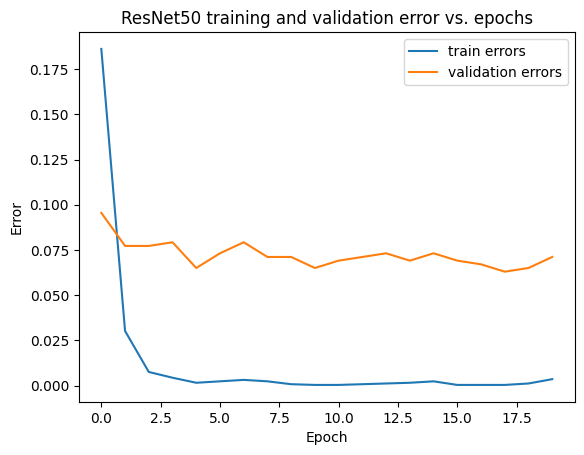

16/16 [==============================] - 3s 127ms/step
Scores for ResNet50 on training data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       564
           1       1.00      1.00      1.00       377
           2       1.00      1.00      1.00       481
           3       1.00      1.00      1.00       550
           4       1.00      1.00      1.00       542

    accuracy                           1.00      2514
   macro avg       1.00      1.00      1.00      2514
weighted avg       1.00      1.00      1.00      2514

Scores for ResNet50 on test data: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       109
           1       0.94      0.90      0.92        73
           2       0.87      0.92      0.90        93
           3       0.95      0.92      0.94       106
           4       0.91      0.91      0.91       104

    accuracy                           0.93       485


In [5]:
#train ResNet50

resnet_model=Sequential()
resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(rate=0.2))
resnet_model.add(Dense(1280, activation='relu'))#add last layer with ReLU activation
resnet_model.add(BatchNormalization())#batch normalization
resnet_model.add(Dropout(rate=0.2))#dropout rate of 0.2
resnet_model.add(Dense(5, activation='softmax'))#add a layer with softmax activation

#ADAM optimizer, multinomial cross entropy loss
resnet_model.compile(optimizer=Adam(0.001), loss=categorical_crossentropy, metrics=['accuracy'])

#perform early stopping using the validation set
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#use ModelCheckpoint to keep the network parameters that have the lowest validation error(loss)
model_checkpoint=ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', mode='min', save_best_only=True)

result=resnet_model.fit(x=np.array(x_train), y=np.array(y_train), epochs=100, batch_size=32,
                 validation_data=(np.array(x_val), np.array(y_val)), callbacks=[early_stopping, model_checkpoint])

#Plot the training and validation errors vs. epochs
plt.plot([1-x for x in result.history['accuracy']], label='train errors')
plt.plot([1-x for x in result.history['val_accuracy']], label='validation errors')
plt.title('ResNet50 training and validation error vs. epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

#Part V

#Report the Confusion Matrix and scores for ResNet50
resnet_model.load_weights('best_weights.h5')#optimal network parameters
y_train_pred_resnet=np.argmax(resnet_model.predict(x_train), axis=-1)
y_test_pred_resnet=np.argmax(resnet_model.predict(x_test), axis=-1)
print('Scores for ResNet50 on training data:','\n', classification_report(np.argmax(y_train, axis=1), y_train_pred_resnet))
print('Scores for ResNet50 on test data:', '\n', classification_report(np.argmax(y_test, axis=1), y_test_pred_resnet))
print('confusion matrix for ResNet50 on training data:','\n', confusion_matrix(np.argmax(y_train, axis=1), y_train_pred_resnet))
print('confusion matrix for ResNet50 on test data:','\n',confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_resnet))

Epoch 1/100
79/79 [==============================] - 18s 143ms/step - loss: 1.2357 - accuracy: 0.8079 - val_loss: 0.5469 - val_accuracy: 0.9065
Epoch 2/100
79/79 [==============================] - 8s 103ms/step - loss: 0.1108 - accuracy: 0.9646 - val_loss: 0.3488 - val_accuracy: 0.9187
Epoch 3/100
79/79 [==============================] - 8s 103ms/step - loss: 0.0517 - accuracy: 0.9853 - val_loss: 0.3315 - val_accuracy: 0.9228
Epoch 4/100
79/79 [==============================] - 8s 101ms/step - loss: 0.0220 - accuracy: 0.9924 - val_loss: 0.3207 - val_accuracy: 0.9248
Epoch 5/100
79/79 [==============================] - 7s 89ms/step - loss: 0.0225 - accuracy: 0.9924 - val_loss: 0.3277 - val_accuracy: 0.9289
Epoch 6/100
79/79 [==============================] - 7s 94ms/step - loss: 0.0162 - accuracy: 0.9932 - val_loss: 0.3321 - val_accuracy: 0.9309
Epoch 7/100
79/79 [==============================] - 7s 89ms/step - loss: 0.0103 - accuracy: 0.9968 - val_loss: 0.3409 - val_accuracy: 0.9228
E

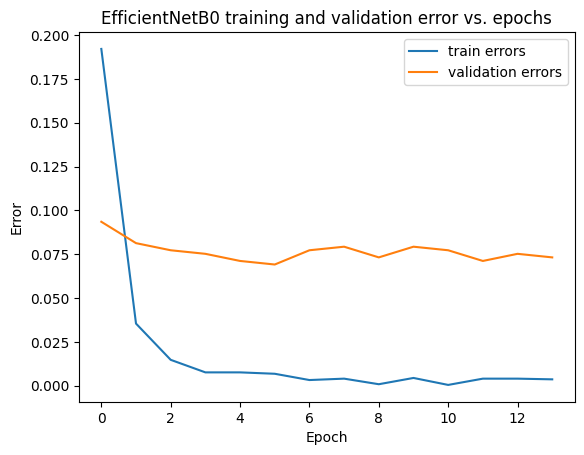

16/16 [==============================] - 3s 88ms/step
Scores for EfficientNetB0 on training data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       564
           1       1.00      1.00      1.00       377
           2       1.00      1.00      1.00       481
           3       1.00      1.00      1.00       550
           4       1.00      1.00      1.00       542

    accuracy                           1.00      2514
   macro avg       1.00      1.00      1.00      2514
weighted avg       1.00      1.00      1.00      2514

Scores for EfficientNetB0 on test data: 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       109
           1       0.90      0.86      0.88        73
           2       0.95      0.94      0.94        93
           3       0.93      0.93      0.93       106
           4       0.89      0.88      0.88       104

    accuracy                           0.92

In [6]:
#train EfficientNetB0

efficientnet_model=Sequential()
efficientnet_model.add(efficientnet)
efficientnet_model.add(Flatten())
efficientnet_model.add(BatchNormalization())
efficientnet_model.add(Dropout(rate=0.2))
efficientnet_model.add(Dense(1280, activation='relu'))#add last layer with ReLU activation
efficientnet_model.add(BatchNormalization())#batch normalization
efficientnet_model.add(Dropout(rate=0.2))#dropout rate of 0.2
efficientnet_model.add(Dense(5, activation='softmax'))#add a layer with softmax activation

efficientnet_model.compile(optimizer=Adam(0.001), loss=categorical_crossentropy, metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint=ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', 
                                 mode='min', save_best_only=True, save_weights_only=True)

result=efficientnet_model.fit(x=np.array(x_train), y=np.array(y_train), epochs=100, batch_size=32,
                 validation_data=(np.array(x_val), np.array(y_val)), callbacks=[early_stopping, model_checkpoint])

#Plot the training and validation errors vs. epochs
plt.plot([1-x for x in result.history['accuracy']], label='train errors')
plt.plot([1-x for x in result.history['val_accuracy']], label='validation errors')
plt.title('EfficientNetB0 training and validation error vs. epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

#Part V

#Report the Confusion Matrix and scores for EfficientNetB0
efficientnet_model.load_weights('best_weights.h5')
y_train_pred_effnet=np.argmax(efficientnet_model.predict(x_train), axis=-1)
y_test_pred_effnet=np.argmax(efficientnet_model.predict(x_test), axis=-1)
print('Scores for EfficientNetB0 on training data:', '\n', classification_report(np.argmax(y_train, axis=1), y_train_pred_effnet))
print('Scores for EfficientNetB0 on test data:', '\n', classification_report(np.argmax(y_test, axis=1), y_test_pred_effnet))
print('confusion matrix for EfficientNetB0 on training data:', '\n',confusion_matrix(np.argmax(y_train, axis=1), y_train_pred_effnet))
print('confusion matrix for EfficientNetB0 on test data','\n',confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_effnet))

Epoch 1/100
79/79 [==============================] - 28s 216ms/step - loss: 1.1244 - accuracy: 0.7904 - val_loss: 1.8847 - val_accuracy: 0.8394
Epoch 2/100
79/79 [==============================] - 13s 160ms/step - loss: 0.1093 - accuracy: 0.9662 - val_loss: 0.7067 - val_accuracy: 0.8801
Epoch 3/100
79/79 [==============================] - 13s 163ms/step - loss: 0.0397 - accuracy: 0.9877 - val_loss: 0.5191 - val_accuracy: 0.9004
Epoch 4/100
79/79 [==============================] - 13s 164ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.4536 - val_accuracy: 0.9004
Epoch 5/100
79/79 [==============================] - 13s 163ms/step - loss: 0.0192 - accuracy: 0.9912 - val_loss: 0.4356 - val_accuracy: 0.9004
Epoch 6/100
79/79 [==============================] - 13s 165ms/step - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.4131 - val_accuracy: 0.9045
Epoch 7/100
79/79 [==============================] - 12s 151ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.4486 - val_accuracy:

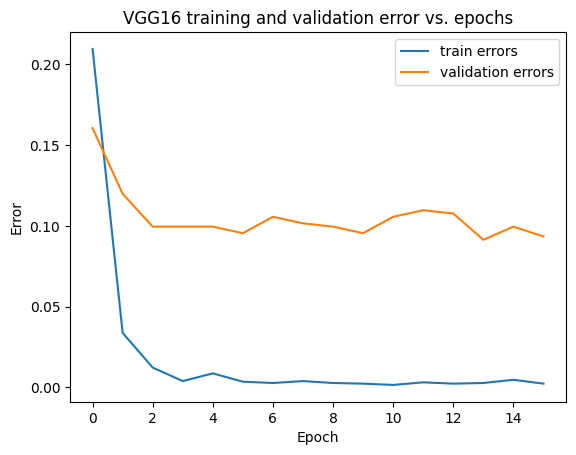

16/16 [==============================] - 3s 196ms/step
Scores for VGG16 on training data 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       564
           1       1.00      1.00      1.00       377
           2       1.00      1.00      1.00       481
           3       1.00      1.00      1.00       550
           4       1.00      1.00      1.00       542

    accuracy                           1.00      2514
   macro avg       1.00      1.00      1.00      2514
weighted avg       1.00      1.00      1.00      2514

Scores for VGG16 on test data 
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       109
           1       0.89      0.89      0.89        73
           2       0.95      0.87      0.91        93
           3       0.96      0.87      0.91       106
           4       0.85      0.95      0.90       104

    accuracy                           0.91       485
   macro

In [6]:
#train VGG16

vgg_model=Sequential()
vgg_model.add(vgg)
vgg_model.add(Flatten())
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(rate=0.2))
vgg_model.add(Dense(1280, activation='relu'))#add last layer with ReLU activation
vgg_model.add(BatchNormalization())#batch normalization
vgg_model.add(Dropout(rate=0.2))#dropout rate of 0.2
vgg_model.add(Dense(5, activation='softmax'))#add a layer with softmax activation

vgg_model.compile(optimizer=Adam(0.001), loss=categorical_crossentropy, metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint=ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', mode='min', save_best_only=True)

result=vgg_model.fit(x=np.array(x_train), y=np.array(y_train), epochs=100, batch_size=32,
                 validation_data=(np.array(x_val), np.array(y_val)), callbacks=[early_stopping, model_checkpoint])

#Plot the training and validation errors vs. epochs
plt.plot([1-x for x in result.history['accuracy']], label='train errors')
plt.plot([1-x for x in result.history['val_accuracy']], label='validation errors')
plt.title('VGG16 training and validation error vs. epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

#Part V

#Report the Confusion Matrix and scores for VGG16
vgg_model.load_weights('best_weights.h5')
y_train_pred_vgg=np.argmax(vgg_model.predict(x_train), axis=-1)
y_test_pred_vgg=np.argmax(vgg_model.predict(x_test), axis=-1)
print('Scores for VGG16 on training data', '\n',classification_report(np.argmax(y_train, axis=1), y_train_pred_vgg))
print('Scores for VGG16 on test data', '\n',classification_report(np.argmax(y_test, axis=1), y_test_pred_vgg))
print('confusion matrix for VGG16 on training data','\n',confusion_matrix(np.argmax(y_train, axis=1), y_train_pred_vgg))
print('confusion matrix for VGG16 on test data','\n',confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_vgg))

**(f) Video Classification Using Moving Averages**

Part i:

In [8]:
#retrain resent model using validation set and save the model with lowest test loss
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint=ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', mode='min', save_best_only=True)
resnet_model.fit(np.concatenate((np.array(x_train), np.array(x_val))), np.concatenate((np.array(y_train), np.array(y_val))),
                    validation_data=(np.array(x_test), np.array(y_test)),
                    epochs=50, batch_size=32, callbacks=[early_stopping, model_checkpoint])
resnet_model.load_weights('best_weights.h5')

Epoch 1/50
94/94 [==============================] - 22s 233ms/step - loss: 0.1598 - accuracy: 0.9591 - val_loss: 0.5278 - val_accuracy: 0.9155
Epoch 2/50
94/94 [==============================] - 20s 217ms/step - loss: 0.1173 - accuracy: 0.9624 - val_loss: 0.4549 - val_accuracy: 0.9175
Epoch 3/50
94/94 [==============================] - 22s 230ms/step - loss: 0.0414 - accuracy: 0.9874 - val_loss: 0.3881 - val_accuracy: 0.9155
Epoch 4/50
94/94 [==============================] - 21s 227ms/step - loss: 0.0102 - accuracy: 0.9957 - val_loss: 0.3443 - val_accuracy: 0.9175
Epoch 5/50
94/94 [==============================] - 21s 221ms/step - loss: 0.0160 - accuracy: 0.9940 - val_loss: 0.3186 - val_accuracy: 0.9258
Epoch 6/50
94/94 [==============================] - 21s 219ms/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.2862 - val_accuracy: 0.9299
Epoch 7/50
94/94 [==============================] - 13s 143ms/step - loss: 0.0070 - accuracy: 0.9970 - val_loss: 0.3304 - val_accuracy: 0.9340

In [9]:
#retrain efficientnet model using validation set and save the model with lowest test loss
tensorflow.debugging.set_log_device_placement(True) 
keras.backend.clear_session()
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint=ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
efficientnet_model.fit(np.concatenate((np.array(x_train), np.array(x_val))), np.concatenate((np.array(y_train), np.array(y_val))),
                    validation_data=(np.array(x_test), np.array(y_test)),
                    epochs=50, batch_size=32, callbacks=[early_stopping, model_checkpoint])
efficientnet_model.load_weights('best_weights.h5')

Epoch 1/50
94/94 [==============================] - 11s 111ms/step - loss: 0.1550 - accuracy: 0.9647 - val_loss: 0.4914 - val_accuracy: 0.8804
Epoch 2/50
94/94 [==============================] - 9s 99ms/step - loss: 0.0795 - accuracy: 0.9744 - val_loss: 0.2706 - val_accuracy: 0.9278
Epoch 3/50
94/94 [==============================] - 9s 100ms/step - loss: 0.0422 - accuracy: 0.9864 - val_loss: 0.2531 - val_accuracy: 0.9278
Epoch 4/50
94/94 [==============================] - 9s 101ms/step - loss: 0.0200 - accuracy: 0.9923 - val_loss: 0.2090 - val_accuracy: 0.9402
Epoch 5/50
94/94 [==============================] - 8s 87ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.2680 - val_accuracy: 0.9340
Epoch 6/50
94/94 [==============================] - 8s 87ms/step - loss: 0.0183 - accuracy: 0.9917 - val_loss: 0.3110 - val_accuracy: 0.9340
Epoch 7/50
94/94 [==============================] - 8s 87ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.2715 - val_accuracy: 0.9464
Epoch 8/5

In [7]:
#retrain vgg model using validation set and save the model with lowest test loss
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint=ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', mode='min', 
                                 save_best_only=True)
vgg_model.fit(np.concatenate((np.array(x_train), np.array(x_val))), np.concatenate((np.array(y_train), np.array(y_val))),
                    validation_data=(np.array(x_test), np.array(y_test)),
                    epochs=50, batch_size=32, callbacks=[early_stopping, model_checkpoint])
vgg_model.load_weights('best_weights.h5')

Epoch 1/50
94/94 [==============================] - 20s 214ms/step - loss: 0.1508 - accuracy: 0.9597 - val_loss: 0.5929 - val_accuracy: 0.8845
Epoch 2/50
94/94 [==============================] - 16s 174ms/step - loss: 0.0546 - accuracy: 0.9784 - val_loss: 0.4605 - val_accuracy: 0.9031
Epoch 3/50
94/94 [==============================] - 15s 156ms/step - loss: 0.0558 - accuracy: 0.9834 - val_loss: 0.4978 - val_accuracy: 0.9052
Epoch 4/50
94/94 [==============================] - 16s 169ms/step - loss: 0.0251 - accuracy: 0.9897 - val_loss: 0.4384 - val_accuracy: 0.9052
Epoch 5/50
94/94 [==============================] - 14s 153ms/step - loss: 0.0211 - accuracy: 0.9927 - val_loss: 0.4753 - val_accuracy: 0.9052
Epoch 6/50
94/94 [==============================] - 14s 154ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.4670 - val_accuracy: 0.9052
Epoch 7/50
94/94 [==============================] - 15s 155ms/step - loss: 0.0102 - accuracy: 0.9963 - val_loss: 0.4501 - val_accuracy: 0.9093

Part ii & iii & iv:

In [11]:
video_dir = '/content/drive/MyDrive/Data/Sport Videos'
video_classes = ["BaseballPitch", "Basketball", "Fencing", "TennisSwing", "VolleyballSpiking"]

#resnet_model

labels_pred=[]
labels_true=[]

for video_class in video_classes:

    print(video_class,':')
    path=os.path.join(video_dir, video_class)
    videos=os.listdir(path)#all videos in each folder
    
    for video in videos:

        if video.endswith('.avi'):

          capture=cv2.VideoCapture(str(os.path.join(path, video)))
          num_frames=int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
          frame_indices=np.linspace(0, num_frames-1, 100, dtype=int)#indices of 100 equally spaced frames

          if num_frames<100:#use all frames if a video has less the 100 frames
            frame_indices=range(num_frames)
          
          frame_probs=[]
          for i in frame_indices:
              capture.set(cv2.CAP_PROP_POS_FRAMES, i)#set frame
              ret, frame=capture.read()#read frame
              if not ret:
                continue
              frame=cv2.resize(frame, (224, 224))
              frame=np.expand_dims(frame, axis=0)

              #predict probability for each frame
              prob=resnet_model.predict(frame, verbose=0)[0]
              frame_probs.append(prob)

          #Calculate the average p of these probability vectors for each video
          avg_probs=np.mean(frame_probs, axis=0)
          #print(video, avg_probs)
          
          label_pred=video_classes[np.argmax(avg_probs)]#Select the class with maximum probability
          labels_pred.append(label_pred)
          labels_true.append(video_class)#store true labels

    print('probability predictions obtained')
#convert labels into consistent format
labels_pred=LabelEncoder().fit_transform(labels_pred)
labels_pred=to_categorical(labels_pred, num_classes=5)
labels_true=LabelEncoder().fit_transform(labels_true)
labels_true=to_categorical(labels_true, num_classes=5)

print('confusion matrix:', '\n', confusion_matrix(np.argmax(labels_true, axis=1), np.argmax(labels_pred, axis=1)))
print('scores:', '\n', classification_report(np.argmax(labels_true, axis=1), np.argmax(labels_pred, axis=1)))

BaseballPitch :
probability predictions obtained
Basketball :
probability predictions obtained
Fencing :
probability predictions obtained
TennisSwing :
probability predictions obtained
VolleyballSpiking :
probability predictions obtained
confusion matrix: 
 [[125   0  18   5   2]
 [ 21   2  49  35  30]
 [  0   0 106   0   5]
 [ 13   0  27 121   6]
 [  1   0  63   1  51]]
scores: 
               precision    recall  f1-score   support

           0       0.78      0.83      0.81       150
           1       1.00      0.01      0.03       137
           2       0.40      0.95      0.57       111
           3       0.75      0.72      0.74       167
           4       0.54      0.44      0.49       116

    accuracy                           0.59       681
   macro avg       0.69      0.59      0.52       681
weighted avg       0.71      0.59      0.54       681



In [12]:
#efficientnet_model
tensorflow.debugging.set_log_device_placement(True) 
keras.backend.clear_session()

labels_pred=[]
labels_true=[]

for video_class in video_classes:

    print(video_class,':')
    path=os.path.join(video_dir, video_class)
    videos=os.listdir(path) #all videos in each folder
    
    for video in videos:

        if video.endswith('.avi'):
          capture=cv2.VideoCapture(str(os.path.join(path, video)))
          num_frames=int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
          frame_indices=np.linspace(0, num_frames-1, 100, dtype=int)#indices of 100 equally spaced frame

          if num_frames<100:#use all frames if a video has less the 100 frames
            frame_indices=range(num_frames)
                    
          frame_probs=[]
          for i in frame_indices:
              capture.set(cv2.CAP_PROP_POS_FRAMES, i)#set frame
              ret, frame = capture.read()#read frame
              if not ret:
                  continue
              frame=cv2.resize(frame, (224, 224))
              frame=np.expand_dims(frame, axis=0)

              #predict probability for each frame
              prob=efficientnet_model.predict(frame, verbose=0)[0]
              frame_probs.append(prob)
          avg_probs = np.mean(frame_probs, axis=0)
          #print(video, avg_probs)
          
          label_pred=video_classes[np.argmax(avg_probs)]#Select the class with maximum probability
          labels_pred.append(label_pred)
          labels_true.append(video_class)#append true label
    
    print('probability predictions obtained')

labels_pred=LabelEncoder().fit_transform(labels_pred)
labels_pred=to_categorical(labels_pred, num_classes=5)
labels_true=LabelEncoder().fit_transform(labels_true)
labels_true=to_categorical(labels_true, num_classes=5)

print('confusion matrix:', '\n', confusion_matrix(np.argmax(labels_true, axis=1), np.argmax(labels_pred, axis=1)))
print('scores:', '\n', classification_report(np.argmax(labels_true, axis=1), np.argmax(labels_pred, axis=1)))

BaseballPitch :
probability predictions obtained
Basketball :
probability predictions obtained
Fencing :
probability predictions obtained
TennisSwing :
probability predictions obtained
VolleyballSpiking :
probability predictions obtained
confusion matrix: 
 [[140   0   9   0   1]
 [  9   1  66   9  52]
 [  0   0 109   0   2]
 [  9   0  15 120  23]
 [  0   0  64   0  52]]
scores: 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       150
           1       1.00      0.01      0.01       137
           2       0.41      0.98      0.58       111
           3       0.93      0.72      0.81       167
           4       0.40      0.45      0.42       116

    accuracy                           0.62       681
   macro avg       0.73      0.62      0.55       681
weighted avg       0.76      0.62      0.57       681



In [8]:
#vgg_model
tensorflow.debugging.set_log_device_placement(True) 
keras.backend.clear_session()

video_dir = '/content/drive/MyDrive/Data/Sport Videos'
video_classes = ["BaseballPitch", "Basketball", "Fencing", "TennisSwing", "VolleyballSpiking"]

labels_pred=[]
labels_true=[]

for video_class in video_classes:

    print(video_class,':')
    path=os.path.join(video_dir, video_class)
    videos=os.listdir(path) #all videos in each folder
    
    for video in videos:

        if video.endswith('.avi'):
          capture=cv2.VideoCapture(str(os.path.join(path, video)))
          num_frames=int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
          frame_indices=np.linspace(0, num_frames-1, 100, dtype=int)#indices of 100 equally spaced frame

          if num_frames<100:#use all frames if a video has less the 100 frames
            frame_indices=range(num_frames)
          frame_probs=[]
          for i in frame_indices:
              capture.set(cv2.CAP_PROP_POS_FRAMES, i)#set frame
              ret, frame = capture.read()#read frame
              if not ret:
                  continue
              frame=cv2.resize(frame, (224, 224))
              frame=np.expand_dims(frame, axis=0)

              #predict probability for each frame
              prob=vgg_model.predict(frame, verbose=0)[0]
              frame_probs.append(prob)
          avg_probs = np.mean(frame_probs, axis=0)
          #print(video, avg_probs)
          
          label_pred=video_classes[np.argmax(avg_probs)]#Select the class with maximum probability
          labels_pred.append(label_pred)
          labels_true.append(video_class)#append true label
    
    print('probability predictions obtained')

labels_pred=LabelEncoder().fit_transform(labels_pred)
labels_pred=to_categorical(labels_pred, num_classes=5)
labels_true=LabelEncoder().fit_transform(labels_true)
labels_true=to_categorical(labels_true, num_classes=5)

print('confusion matrix:', '\n', confusion_matrix(np.argmax(labels_true, axis=1), np.argmax(labels_pred, axis=1)))
print('scores:', '\n', classification_report(np.argmax(labels_true, axis=1), np.argmax(labels_pred, axis=1)))

BaseballPitch :
probability predictions obtained
Basketball :
probability predictions obtained
Fencing :
probability predictions obtained
TennisSwing :
probability predictions obtained
VolleyballSpiking :
probability predictions obtained
confusion matrix: 
 [[130   0  14   5   1]
 [  3   1  70  41  22]
 [  0   0 110   0   1]
 [  3   0  26 138   0]
 [  0   0  83   4  29]]
scores: 
               precision    recall  f1-score   support

           0       0.96      0.87      0.91       150
           1       1.00      0.01      0.01       137
           2       0.36      0.99      0.53       111
           3       0.73      0.83      0.78       167
           4       0.55      0.25      0.34       116

    accuracy                           0.60       681
   macro avg       0.72      0.59      0.52       681
weighted avg       0.74      0.60      0.54       681



Conclusions: ResNet50 has the best performance on images among three models since it has the highest test accuracy of 0.93. After retraining the models using validation set, EfficientNetB0 seems to perform better on videos with an accuracy of 0.62.